In [1]:
import torch
import torch.nn as nn
import torch.utils.data
import torch.utils.data as data_utils
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
from tqdm import tqdm
import timeit

C:\Users\matth\anaconda3\envs\earthquake-prediction\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Input data:  
- CCLE_expression.csv  
Gene expression TPM (transcript per million) values of the protein coding genes for DepMap cell lines  
log2(TPM+1) goes from 0.00 to 17.78


- CRISPR_gene_effect.csv
Gene effect of the protein coding genes for DepMap cell lines
Gene Effect scores derived from CRISPR knockout screens published by Broad’s Achilles and Sanger’s SCORE projects.  
Negative scores imply cell growth inhibition and/or death following gene knockout. Scores are normalized such that nonessential genes have a median score of 0 and independently identified common essentials have a median score of -1.
SCORE goes from -3.89 to 2.73. 

- preprocess/index_to_protein_and_gene.txt

- preprocess/adjacence_matrix.txt

Genes:16,481  
Cell Lines:1,081  
Primary Diseases:31 (?)  
Lineages:28 (?)

## Retrieve data 

In [2]:
gene_expression = pd.read_csv('preprocess/gene_expression.csv').set_index('DepMap')
gene_effect = pd.read_csv('preprocess/gene_effect.csv').set_index('DepMap')

In [3]:
protein_info = pd.read_csv('preprocess/index_to_protein_and_gene.txt', header=None, sep=' ')
protein_info = protein_info.rename(columns={0:'index', 1:'protein', 2:'gene_ID'})
protein_info = protein_info.set_index('index')

In [4]:
#adjacence_matrix = np.loadtxt('preprocess/adjacence_matrix.txt', delimiter=' ', dtype=int)
index_links = pd.read_csv("preprocess/index_links.csv")

In [5]:
gene_expression.head()

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
DepMap,,,,,,,,,,,,,,,,,,,,,
ACH-000001,3.116032,0.056584,0.226509,0.111031,0.000000,1.035624,0.176323,5.700440,4.144046,0.790772,...,5.080658,6.675957,0.978196,1.914565,4.700994,3.282440,2.797013,6.821455,3.010780,4.381975
ACH-000002,1.395063,0.000000,0.275007,0.111031,0.000000,0.137504,0.000000,5.078951,1.948601,0.000000,...,3.204767,6.388017,0.097611,1.000000,3.925050,0.000000,1.070389,5.963474,2.169925,3.255501
ACH-000003,1.400538,4.305241,0.321928,0.150560,0.000000,4.219556,0.097611,5.195348,3.962549,1.687061,...,4.013462,7.528181,0.464668,1.555816,2.851999,0.704872,2.316146,7.302867,2.659925,2.748461
ACH-000004,4.178715,0.000000,0.214125,0.344828,0.070389,0.097611,0.000000,6.336819,3.231125,0.000000,...,4.276497,6.098664,0.765535,1.622930,3.619413,0.014355,2.032101,7.002252,3.444932,4.910733
ACH-000005,4.003602,0.014355,0.137504,0.014355,0.000000,0.028569,0.000000,6.337176,3.781360,0.000000,...,5.628482,6.785289,0.807355,1.773996,3.763412,0.014355,2.761285,6.826421,3.524816,5.592457


In [6]:
gene_effect.head()

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
DepMap,,,,,,,,,,,,,,,,,,,,,
ACH-000001,-0.134808,0.059764,-0.008665,-0.003572,-0.106211,-0.008257,0.018711,-0.291985,0.010921,0.064932,...,-0.037619,-0.116524,-0.029331,0.105940,0.147605,-0.119822,0.063387,0.160857,0.058648,-0.316792
ACH-000004,0.081853,-0.056401,-0.106738,-0.014499,0.078209,-0.137562,0.168657,-0.198560,0.133372,0.151300,...,-0.030901,-0.262220,0.136406,0.031327,0.093763,-0.079692,-0.173709,0.153632,0.175627,-0.040869
ACH-000005,-0.094196,-0.014598,0.100426,0.169103,0.032363,-0.148050,0.168931,-0.244777,-0.086871,-0.036037,...,0.039434,-0.336925,-0.095528,-0.035541,-0.035612,-0.040183,-0.165464,0.077343,0.019387,-0.085687
ACH-000007,-0.011544,-0.123189,0.080692,0.061046,-0.013454,-0.016922,-0.029474,-0.206516,-0.063998,0.139288,...,-0.229303,-0.463191,0.061641,0.190301,0.119388,-0.036695,-0.182449,-0.146936,-0.189451,-0.281167
ACH-000009,-0.050782,-0.037466,0.068885,0.090375,0.012634,-0.079339,-0.017808,-0.183192,0.006227,-0.001700,...,-0.157219,-0.318765,0.015761,0.196949,-0.045874,-0.186805,-0.275629,-0.001227,-0.049140,-0.240582


In [7]:
protein_info.head()

,protein,gene_ID
index,,
0,9606.ENSP00000263100,A1BG
1,9606.ENSP00000378868,A1CF
2,9606.ENSP00000323929,A2M
3,9606.ENSP00000299698,A2ML1
4,9606.ENSP00000475261,A3GALT2


## Creating Dataset

In [8]:
# gene effect and gene expression don't have the same number of rows for some reason.

In [59]:
indices = set(gene_effect.index).intersection(gene_expression.index)
indices = list(indices)
gene_effect_ = gene_effect[gene_effect.index.isin(indices)]
gene_expression_ = gene_expression[gene_expression.index.isin(indices)]

In [60]:
gene_expression_np = gene_expression_.to_numpy()
gene_effect_np = gene_effect_.to_numpy()

In [61]:
edge_index = index_links[['index1', 'index2']].to_numpy().T
edge_attr = index_links['combined_score'].to_numpy()

**Normalize Data**

In [76]:
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scale_effect = StandardScaler()
scale_expression = StandardScaler()
scale_attr = MinMaxScaler()

scaled_effect = scale_effect.fit_transform(gene_effect_np)
scaled_expression = scale_expression.fit_transform(gene_expression_np)
scaled_attr = scale_attr.fit_transform(edge_attr)

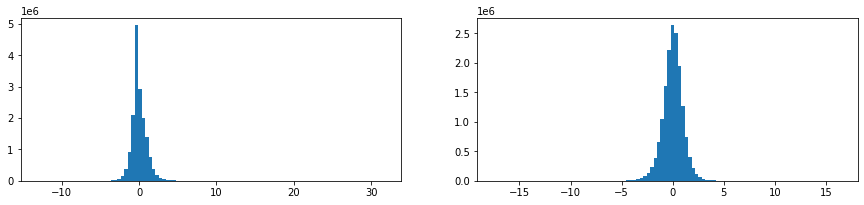

In [77]:
fig, ax = plt.subplots(1,2, figsize = (15,3))
_ = ax[0].hist(np.hstack(scaled_expression), bins = 100)
_ = ax[1].hist(np.hstack(scaled_effect), bins = 100)

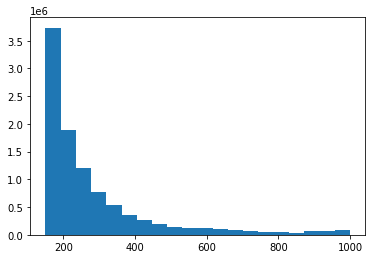

In [78]:
_ = plt.hist(scaled_attr[:,0], bins = 20)

**Change Data Type**

In [80]:
x = torch.tensor(scaled_expression, dtype = torch.float32)
y = torch.tensor(scaled_effect, dtype = torch.float32)
edge_index = torch.tensor(edge_index, dtype = torch.long)
edge_attr = torch.tensor(scaled_attr, dtype = torch.float32).view(-1, 1)

C:\Users\matth\AppData\Local\Temp\ipykernel_30064\1327882362.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edge_index, dtype = torch.long)


In [81]:
print(x.shape)
print(y.shape)

torch.Size([1001, 16481])
torch.Size([1001, 16481])


In [82]:
# sampling one cell line
#x = x[0].view(-1,1)
#y = y[0].view(-1,1)

In [83]:
print(x.shape)
print(y.shape)

torch.Size([1001, 16481])
torch.Size([1001, 16481])


In [84]:
print(edge_attr.shape)
print(edge_index.shape)

torch.Size([9928270, 1])
torch.Size([2, 9928270])


**Create Data Loaders**

In [85]:
#random_list = np.random.randint()
#edge_index_ = edge_index[:,:100]
#edge_attr_ = edge_attr[:100]
#sorted_ = torch.unique( torch.reshape(edge_index_, (-1,1))[:,0] , sorted = True)
#x_ = x[sorted_]

In [86]:
from torch_geometric.data import Data, DataLoader
data = Data(x = x, edge_index = edge_index, edge_attr = edge_attr, y = y)

device = torch.device('cuda')
data = data.to(device)

#train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

**Plot Graph**

In [87]:
data

Data(x=[1001, 16481], edge_index=[2, 9928270], edge_attr=[9928270, 1], y=[1001, 16481])

In [88]:
#from torch_geometric.utils import to_networkx
#vis = to_networkx(data)

In [89]:
#import networkx as nx
#nx.draw(vis)

**Defining Dataset**

In [90]:
# I wanted to create a clean dataset but we have the following problem:
# datasets store each data point individually
# in our case, each point corresponds to a cell line
# but we don't want to store the edge attributes (PPI scores) again every time because they're always the same (redundant)
# there's probably a way but I couldn't find it yet

In [91]:
import os
import os.path as osp
import torch
from torch_geometric.data import Dataset, download_url
from scipy import stats
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import Data, DataLoader
from tqdm import tqdm


class AchillesDataset(Dataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)

    @property
    def raw_file_names(self):
        return ['gene_expression.csv', 'gene_effect.csv', 'index_links.csv']

    @property
    def processed_file_names(self):
        return 'processed_achilles.pt'

    def download(self):
        pass

    def process(self):
        
        # read raw data
        self.expression = pd.read_csv(self.raw_paths[0]).set_index('DepMap')
        self.effect = pd.read_csv(self.raw_paths[1]).set_index('DepMap')
        self.links = pd.read_csv(self.raw_paths[2])
        
        # clean data
        indices = set(self.effect.index).intersection(self.expression.index)
        indices = list(indices)
        gene_effect_ = gene_effect[self.effect.index.isin(indices)]
        gene_expression_ = self.expression[self.expression.index.isin(indices)]
        
        # convert to numpy array
        gene_expression_np = gene_expression_.to_numpy()
        gene_effect_np = gene_effect_.to_numpy()
        
        # retrieve sparse adjacency matrix and PPI scores
        edge_index = index_links[['index1', 'index2']].to_numpy().T
        edge_attr = index_links['combined_score'].to_numpy()
        
        # standardize data
        scale_effect = StandardScaler()
        scale_expression = StandardScaler()
        scaled_effect = scale_effect.fit_transform(gene_effect_np)
        scaled_expression = scale_expression.fit_transform(gene_expression_np)
        
        # convert to tensor
        x = torch.tensor(scaled_expression, dtype = torch.float32)
        y = torch.tensor(scaled_effect, dtype = torch.float32)
        edge_index = torch.tensor(edge_index, dtype = torch.long)
        edge_attr = torch.tensor(edge_attr, dtype = torch.float32).view(-1, 1)
        
        # store indivual data points
        for i in tqdm(range(x.shape[0])):
            data = Data(x = x[i].view(-1,1),
                       edge_index = edge_index,
                       edge_attr = edge_attr,
                       y = y[i].view(-1,1),
                       )
            torch.save(data, os.path.join(self.processed_dir,
                                         f'data_{i}.pt'))

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
        return data

In [92]:
#dataset = AchillesDataset(root = os.path.join(os.getcwd(), 'preprocess'))

## Create Graph Model

In [93]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    
    def __init__(self, edge_index, edge_attr):
        super().__init__()
        
        self.edge_attr = edge_attr
        self.edge_index = edge_index
        self.conv1 = GCNConv(1, 1, edge_weights = self.edge_attr)
        
    def forward(self, x_input):
        x = self.conv1(x_input, self.edge_index)
        x = F.relu(x)
        return x


In [94]:
n_epochs = 100
device = 'cuda'

N_cl = x.shape[0] # Number of cell lines
N_cl_per_epo = int( 0.01 * N_cl ) # Number of cell lines per epoch

x = x.to(device)
y = y.to(device)
edge_attr = edge_attr.to(device)
edge_index = edge_index.to(device)

losses = []

# model takes edge_index, edge_attr as inputs
model = GCN(edge_index, edge_attr)
model = model.to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()

for epoch in tqdm(range(n_epochs)):
    
    rand_index = np.random.randint(0, N_cl, N_cl_per_epo)
    
    for i, idx in enumerate(rand_index):
        optimizer.zero_grad()
        out = model(x[idx].view(-1,1))
        loss = F.mse_loss(out, y[idx].view(-1,1))
        loss.backward()
        
        if (i == N_cl_per_epo - 1) or (i == 0 and epoch == 0):
            losses.append(loss.item())
            
        optimizer.step()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.83it/s]


In [96]:
n_epochs = 100
device = 'cuda'

N_cl = x.shape[0] # Number of cell lines
N_cl_per_epo = int( 0.01 * N_cl ) # Number of cell lines per epoch

x = x.to(device)
y = y.to(device)
edge_attr = edge_attr.to(device)
edge_index = edge_index.to(device)

losses = []

# model takes edge_index, edge_attr as inputs
model = GCN(edge_index, edge_attr)
model = model.to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
idx = 0


for epoch in tqdm(range(n_epochs)):
    optimizer.zero_grad()
    out = model(x[idx].view(-1,1))
    loss = F.mse_loss(out, y[idx].view(-1,1))
    loss.backward()   
    losses.append(loss.item())
    optimizer.step()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.88it/s]


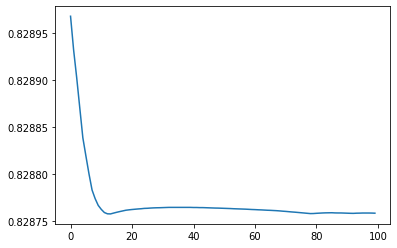

In [97]:
plt.plot(losses)

In [ ]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')
>>> Accuracy: 0.8150